In [3]:

# YouTube Trending Video Analytics - Full Pipeline

## 1. Import Libraries
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import sqlite3

sns.set(style="whitegrid")



In [5]:

## 2. Load and Clean Data from Multiple Regions
regions = ["US", "IN", "GB", "CA", "MX", "JP", "DE"]
dfs = []

for region in regions:
    try:
        df = pd.read_csv(f"{region}videos.csv", encoding="ISO-8859-1")
    except UnicodeDecodeError:
        df = pd.read_csv(f"{region}videos.csv", encoding="utf-16")
    df["region"] = region
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Standardize column names
df.columns = [col.lower().strip().replace(" ", "_") for col in df.columns]



In [7]:
## 3. Load Category Mapping (e.g., US_category_id.json)
def load_category_mapping(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return {int(item["id"]): item["snippet"]["title"] for item in data["items"]}

category_mapping = load_category_mapping("US_category_id.json")
df["category_name"] = df["category_id"].map(category_mapping)



In [18]:
## 4. Sentiment Analysis on Titles
df["title_sentiment"] = df["title"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df["sentiment_label"] = df["title_sentiment"].apply(
    lambda x: "positive" if x > 0 else "negative" if x < 0 else "neutral"
)


In [ ]:

## 5. Analyze Trending Duration
df["trending_date"] = pd.to_datetime(df["trending_date"], errors="coerce")
df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")
df["trending_days"] = (df["trending_date"] - df["publish_time"]).dt.days



In [23]:
## 6. Save to SQL and Run Category Ranking
conn = sqlite3.connect("youtube_trending.db")
df.to_sql("videos", conn, if_exists="replace", index=False)

query = '''
SELECT category_name, AVG(views) AS avg_views
FROM videos
GROUP BY category_name
ORDER BY avg_views DESC
'''
category_ranking = pd.read_sql_query(query, conn)
conn.close()

print("Top Categories by Average Views:")
print(category_ranking.head())


Top Categories by Average Views:
          category_name     avg_views
0                 Music  7.230488e+06
1                Movies  2.895057e+06
2      Film & Animation  1.936055e+06
3  Science & Technology  1.245591e+06
4         Entertainment  1.147270e+06


In [ ]:
# Convert both datetime columns safely
df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")
df["trending_date"] = pd.to_datetime(df["trending_date"], errors="coerce")

# Remove timezone info from both (if present)
df["publish_time"] = df["publish_time"].dt.tz_localize(None)
df["trending_date"] = df["trending_date"].dt.tz_localize(None)

# Now subtract safely
df["trending_duration"] = (df["trending_date"] - df["publish_time"]).dt.days


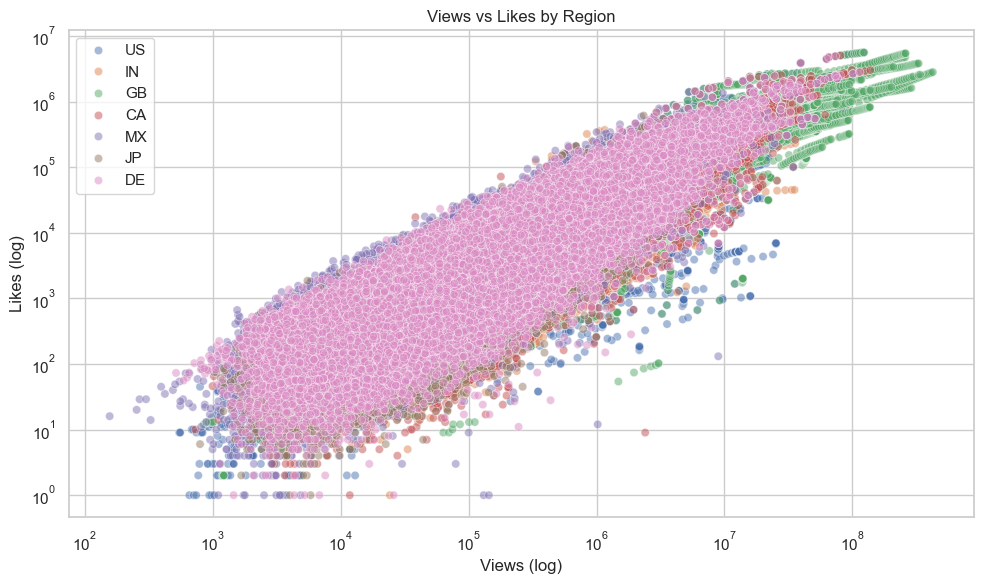

In [25]:

## 7. Visualizations

# A. Views vs Likes (Log Scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="views", y="likes", hue="region", alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.title("Views vs Likes by Region")
plt.xlabel("Views (log)")
plt.ylabel("Likes (log)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



C:\Users\Maniswethu\AppData\Local\Temp\ipykernel_5704\159120713.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="category_name", y="views", palette="Set2")


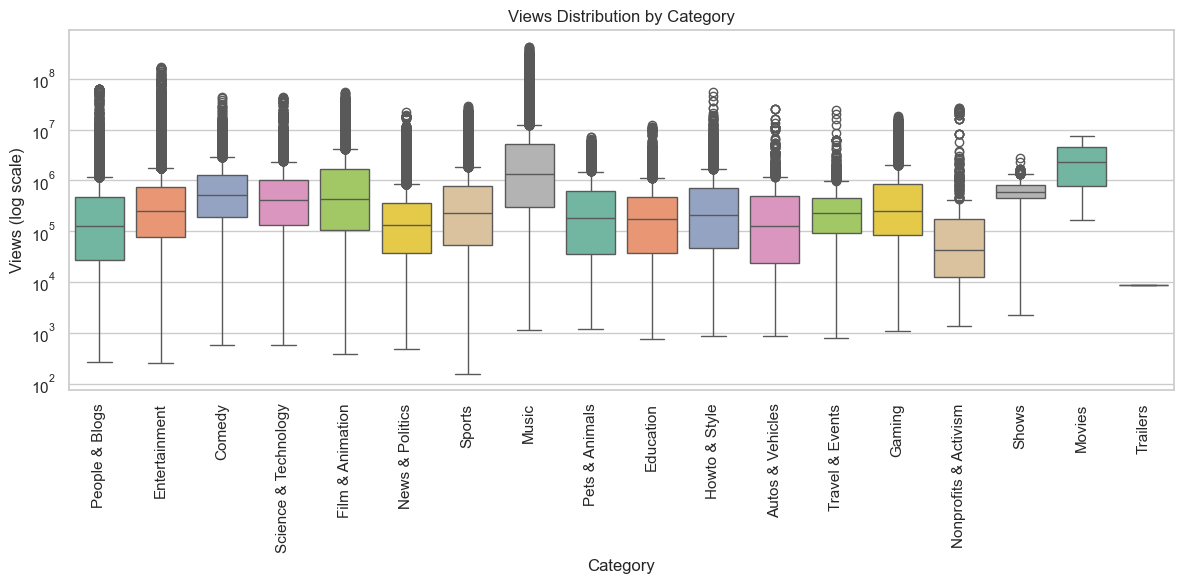

In [27]:
# B. Boxplot of Views by Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="category_name", y="views", palette="Set2")
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Views Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Views (log scale)")
plt.tight_layout()
plt.show()


C:\Users\Maniswethu\AppData\Local\Temp\ipykernel_5704\1114325166.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label", palette="coolwarm")


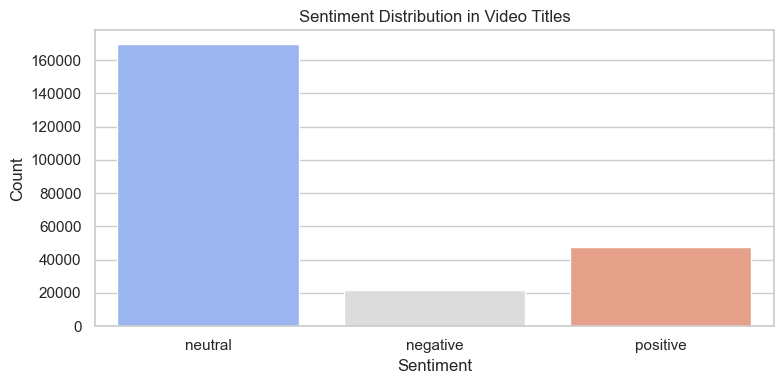

In [29]:

# C. Sentiment Count Plot
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="sentiment_label", palette="coolwarm")
plt.title("Sentiment Distribution in Video Titles")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



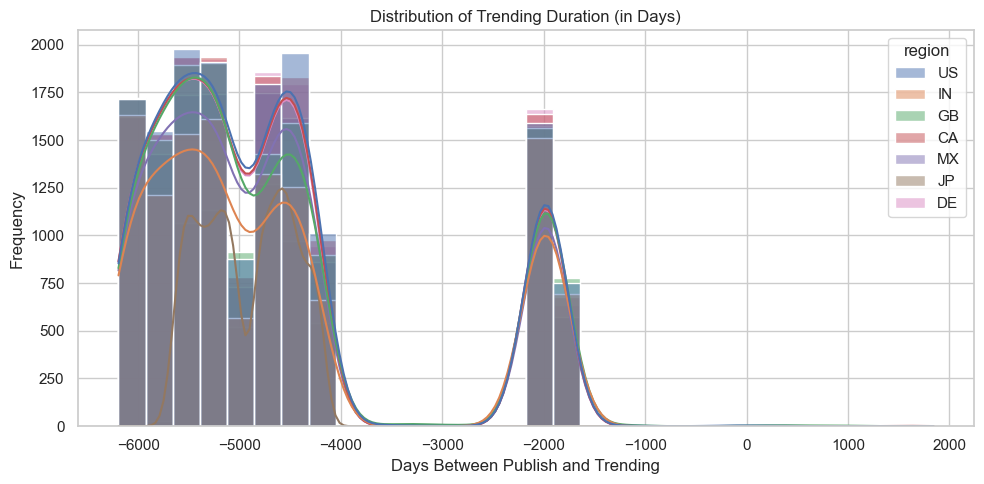

In [35]:
# D. Trending Duration Histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="trending_days", hue="region", bins=30, kde=True)
plt.title("Distribution of Trending Duration (in Days)")
plt.xlabel("Days Between Publish and Trending")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



In [37]:
## 8. Export Cleaned Data for Tableau or Further Use
df.to_csv("cleaned_youtube_trending.csv", index=False)
